Now go on to classify the real majorana data！

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

good_data_small = np.load('datasets/True_majsts_data_small.npy')
good_data_large = np.load('datasets/True_majsts_data_large.npy')
bad_data_small = np.load('datasets/Andreev_majsts_data_small.npy')
bad_data_large = np.load('datasets/Andreev_majsts_data_large.npy')
ugly_data_small = np.load('datasets/Ugly_majsts_data_small.npy')
ugly_data_large = np.load('datasets/Ugly_majsts_data_large.npy')

good_data = np.concatenate([good_data_small, good_data_large], axis=0)
bad_data = np.concatenate([bad_data_small, bad_data_large], axis=0)
ugly_data = np.concatenate([ugly_data_small, ugly_data_large], axis=0)

N1, N2, N3 = len(good_data), len(bad_data), len(ugly_data)
data = np.concatenate([good_data, bad_data, ugly_data], axis=0)

N = len(data)
# we can keep the order, because scikit can shuffle them later
labels = np.concatenate([np.ones(N1), np.zeros(N2), np.zeros(N3)])
np.shape(data)

(12000, 28, 28)

**Note** : To include the size effect, we have a zoom-in and zoom-out version of training data mixed together. 

To make the machine learning more confusing (Adversarial attack), we can add Gaussain noise smearing.

In [2]:
# sigma=3, ampl=0.1
for i in range(N):
    data[i] += 0.2 * np.random.normal(size=(28, 28))
    data[i] = gaussian_filter(data[i], sigma=2)
data = data.reshape((N, -1))
np.shape(data)

(12000, 784)

Now PCA first for 2D.

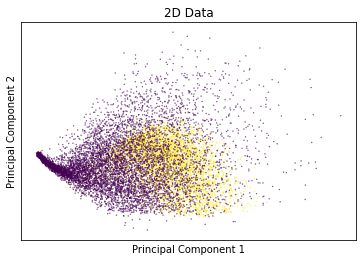

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels.ravel(), s=0.1, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Data')
plt.xticks([])
plt.yticks([])
#plt.colorbar(label='Label')
plt.savefig('2dbefore_anomaly.png')
plt.show()

2D PCA is no longer sufficient for classification.

We can use **Anomaly Detection** method to eliminate some unrealistic data out of the training dataset.

For example, we use Isolation Forest to post process.

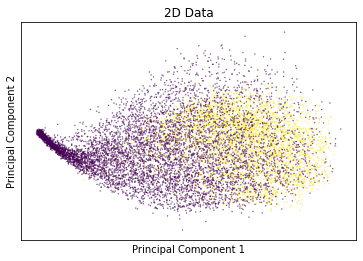

In [4]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1, random_state=42)
clf.fit(data)

# filter
predictions = clf.predict(data)
data = data[predictions == 1]
data_pca = pca.fit_transform(data)
labels = labels[predictions == 1]

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels.ravel(), s=0.1, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Data')
plt.xticks([])
plt.yticks([])
#plt.colorbar(label='Label')
plt.savefig('2dafter_anomaly.png')
plt.show()

Accuracy: 0.7774074074074074


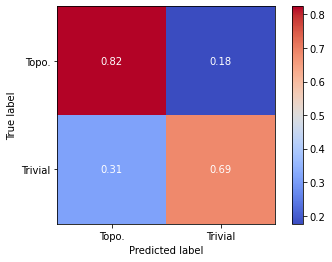

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data_pca, labels.ravel(), test_size=0.25, random_state=42)

# Create a SVC with a linear kernel
svm = SVC(kernel='linear')

# Train the model
svm.fit(X_train, y_train)

# Predict on the test data
y_pred = svm.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Topo.', 'Trivial']).plot(cmap='coolwarm')

# Change text colors
for text in disp.text_:
    for subtext in text:
        subtext.set_color('white')

plt.savefig('2dlinear_confusion.svg')

# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Great job! Now try random forest.

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, labels.ravel(), test_size=0.25, random_state=42)
# Train the model on the PCA-transformed data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)
# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9281481481481482


Try xgboost.

Accuracy: 0.9385185185185185


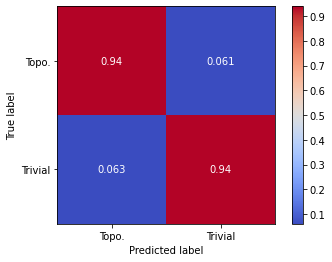

In [11]:
import xgboost as xgb
import pickle
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data, labels.ravel(), test_size=0.25, random_state=42)

# Create DMatrix for train data
dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)

# Set the parameters
params = {
    'objective': 'binary:logistic'}
'''
    'max_depth': 6,
    'eta': 0.1,
    "subsample": 1,
    "gamma": 5,
    "lambda": 0,
    "alpha": 0.3
}
'''
# Train the final model
bst = xgb.train(params, dmatrix_train, num_boost_round=200)

# Make predictions on test data
y_pred = bst.predict(dmatrix_test)
y_pred = np.array([1 if p > 0.5 else 0 for p in y_pred])


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Topo.', 'Trivial']).plot(cmap='coolwarm')

# Change text colors
for text in disp.text_:
    for subtext in text:
        subtext.set_color('white')

#plt.savefig('1dboost_confusion.svg')
# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


with open('clf_xgboost_2d.pickle', 'wb') as f:
    pickle.dump(bst, f)

Accuracy: 0.9366666666666666


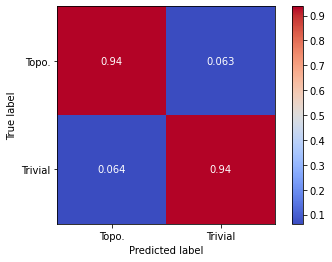

In [8]:
import xgboost as xgb
# Create an XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, labels.ravel(), test_size=0.25, random_state=42)
# Train the model
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Topo.', 'Trivial']).plot(cmap='coolwarm')

# Change text colors
for text in disp.text_:
    for subtext in text:
        subtext.set_color('white')

plt.savefig('2dboost_confusion.svg')
# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# export model
import pickle

with open('clf_xgboost.pickle', 'wb') as f:
    pickle.dump(clf, f)

Then we draw some good figures. For PCA we want pattern:

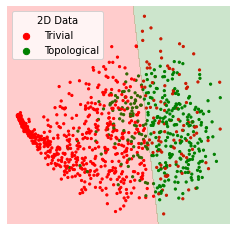

In [9]:
from sklearn.svm import SVC

# Control the figure size
plt.figure(figsize=(4, 4))

# Randomly pick a subset of data points
n_samples = 1000  # Number of samples you want to plot
random_indices = np.random.choice(data_pca.shape[0], n_samples, replace=False)
subset_data_pca = data_pca[random_indices, :]
subset_labels = labels[random_indices]

# Fit Linear SVM
clf = SVC(kernel='linear', C=1)
clf.fit(subset_data_pca, subset_labels)

# Plotting points
colors = ['red' if label == 0 else 'green' for label in subset_labels]
plt.scatter(subset_data_pca[:, 0], subset_data_pca[:, 1], c=colors, s=5)

# Plotting the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot filled contour. Note the use of levels to create areas.
ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], colors=['red', 'green'], alpha=0.2)

# Hide the axes
plt.axis('off')

# Legend
for color, label in zip(['red', 'green'], ['Trivial', 'Topological']):
    plt.scatter([], [], c=color, s=40, label=label)
plt.legend(scatterpoints=1, title='2D Data')

plt.savefig('2dpca.svg')
plt.show()
